## Reflexion

The [Reflexion pattern](https://arxiv.org/pdf/2303.11366), introduced by Shinn et al., extends basic reflection by combining self-critique with external knowledge integration and structured output parsing. 
Unlike simple reflection, Reflexion allows an agent to learn from mistakes in real time while leveraging additional information.
The workflow typically follows these steps:
- Initial Generation: The agent produces a response along with self-critique and research queries.
- External Research: Knowledge gaps identified during critique trigger web searches or other information retrieval.
- Knowledge Integration: New insights are incorporated into an improved response.
- Iterative Refinement: The agent repeats the cycle until the response meets desired quality thresholds.

### Setup

In [11]:
# Required imports
from langchain_aws import ChatBedrock
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from pydantic import ValidationError, BaseModel, Field
from typing import Literal, Annotated
from typing_extensions import TypedDict
from dotenv import load_dotenv
from IPython.display import Image, display
import json
import datetime


In [12]:
# Load environment variables
load_dotenv()
load_dotenv(dotenv_path="../.env", override=True)

False

### Define LLM 

In [13]:
# Initialize LLM - Anthropic Claude via AWS Bedrock
llm = ChatBedrock(
    model_id="anthropic.claude-3-5-sonnet-20241022-v2:0",
    region_name="us-west-2",
    temperature=0
)

At its core, a Reflexion agent is built around an Actor, an agent that generates an initial response, critiques it, and then re-executes the task with improvements. Supporting this loop are a few critical sub-components:
- Tool execution: access to external knowledge sources.
- Initial responder: generates the first draft along with self-reflection.
- Revisor/Revision: produces refined outputs by incorporating prior reflections.

### Construct tools
Since Reflexion requires external knowledge, we first define a tool to fetch information from the web. Here we use the TavilySearchResults tool, a wrapper around the Tavily Search API, enabling our agent to perform web searches and gather supporting evidence.


In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

# Initialize search tool
web_search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=web_search, max_results=5)

### Define the Prompt Template
Next, let's define the prompt that will guide this actor agent's behavior. Prompts serve as the "role description" for an agent, specifying what it should and should not do. The agent is instructed to:
- Provide an initial explanation.
- Reflect and critique its own answer.
- Generate search queries to fill knowledge gaps.

In [ ]:
# Agent prompt template
actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert technical educator specializing in machine learning and neural networks.
                Current time: {time}
                1. {primary_instruction}
                2. Reflect and critique your answer. Be severe to maximize improvement.
                3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<s>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)

### Enforce Structured Output
When dealing with multi-step workflows, it's always recommended to define structured output models for each sub-agent. To ensure consistency, we define structured outputs using Pydantic models:

In [ ]:

# Pydantic models for structured output
class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")

class GenerateResponse(BaseModel):
    """Generate response. Provide an answer, critique, and then follow up with search queries to improve the answer."""
    
    response: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    research_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


For this, we use Pydantic's BaseModel to define two data classes:
- Reflection captures the self-critique, requiring the agent to highlight what information is missing and what is superfluous (unnecessary).
- GenerateResponse structures the final output. It ensures the agent provides its main response, includes a reflection (based on the Reflection class), and supplies a list of research_queries.

This structured approach guarantees that our agents produce consistent and parseable responses.

### Add Retry Logic
Structured parsing can fail if the output doesn't match the schema. To address this, we add retry logic with schema feedback:

In [ ]:
# Agent with retry logic
class AdaptiveResponder:
    def __init__(self, chain, output_parser):
        self.chain = chain
        self.output_parser = output_parser
    
    def generate(self, conversation_state: dict):
        llm_response = None
        for retry_count in range(3):
            llm_response = self.chain.invoke(
                {"messages": conversation_state["messages"]}, {"tags": [f"attempt:{retry_count}"]}
            )
            try:
                self.output_parser.invoke(llm_response)
                return {"messages": llm_response}
            except ValidationError as validation_error:
                # Fix: Convert schema dict to JSON string
                schema_json = json.dumps(self.output_parser.model_json_schema(), indent=2)
                conversation_state = conversation_state + [
                    llm_response,
                    ToolMessage(
                        content=f"{repr(validation_error)}\n\nPay close attention to the function schema.\n\n{schema_json}\n\nRespond by fixing all validation errors.",
                        tool_call_id=llm_response.tool_calls[0]["id"],
                    ),
                ]
        return {"messages": llm_response}


This brings us to an important concept: retry logic with schema feedback. When structured outputs fail validation, we provide the schema and error details back to the LLM for self-correction.

### Bind the Data Model
We now bind the GenerateResponse model as a tool. This forces the LLM to output exactly in the defined structure.

In [ ]:
# Initial answer chain
initial_response_chain = actor_prompt_template.partial(
    primary_instruction="Provide a detailed ~250 word explanation suitable for someone with basic programming background.",
    function_name=GenerateResponse.__name__,
) | llm.bind_tools(tools=[GenerateResponse])

response_parser = PydanticToolsParser(tools=[GenerateResponse])

initial_responder = AdaptiveResponder(
    chain=initial_response_chain, output_parser=response_parser
)

After invoking initial_response_chain, we'll get a structured output that includes the initial answer, the self-critique, and the generated search queries. Let's try it out by testing our initial responder with a simple query.

In [17]:
example_question = "What is the difference between supervised and unsupervised learning?"
initial = initial_responder.generate(
    {"messages": [HumanMessage(content=example_question)]}
)

initial

{'messages': AIMessage(content="I'll explain the key differences between supervised and unsupervised learning using the GenerateResponse function.", additional_kwargs={'usage': {'prompt_tokens': 660, 'completion_tokens': 524, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 1184}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'anthropic.claude-3-5-sonnet-20241022-v2:0', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, response_metadata={'usage': {'prompt_tokens': 660, 'completion_tokens': 524, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 1184}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'anthropic.claude-3-5-sonnet-20241022-v2:0', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='run--316a2aa2-7cbe-4e12-8814-45121515a285-0', tool_calls=[{'name': 'GenerateResponse', 'args': {'response': "Supervised and unsupervised learning represent two fundamental approaches in machine learning th

### Revision
The Revision step represents the final stage of the Reflection loop. Its purpose is to combine three critical elements: the original draft, the self-critique, and the research results,  to produce a refined, evidence-backed response.
We start by defining a new instruction set (revise_instructions) that explicitly guides the Revisor. These instructions stress the importance of:
- Integrating critique into the revision process
- Adding numerical citations tied to the research evidence
- Differentiating correlation from causation in explanations
- Including a structured References section with clean URLs only

In [ ]:
# Revision instructions
improvement_guidelines = """Revise your previous explanation using the new information.
    - You should use the previous critique to add important technical details to your explanation.
    - You MUST include numerical citations in your revised answer to ensure it can be verified.
    - Add a "References" section to the bottom of your answer (which does not count towards the word limit).
    - For the references field, provide a clean list of URLs only (e.g., ["https://example.com", "https://example2.com"])
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
    - Keep the explanation accessible for someone with basic programming background while being technically accurate.
"""

To enforce output structure, we introduce a Pydantic schema, ImproveResponse. This class extends GenerateResponse and introduces an additional sources field, ensuring that each improved answer comes with verifiable references.

In [ ]:
# Revision instructions
class ImproveResponse(GenerateResponse):
    """Improve your original answer to your question. Provide an answer, reflection,
    cite your reflection with references, and finally
    add search queries to improve the answer."""
    
    sources: list[str] = Field(
        description="List of reference URLs that support your answer. Each reference should be a clean URL string."
    )


With the schema defined, we now construct the revision chain by binding the guidelines to the LLM and parsing its outputs:

In [ ]:

# Revision chain
improvement_chain = actor_prompt_template.partial(
    primary_instruction=improvement_guidelines,
    function_name=ImproveResponse.__name__,
) | llm.bind_tools(tools=[ImproveResponse])

improvement_parser = PydanticToolsParser(tools=[ImproveResponse])
response_improver = AdaptiveResponder(chain=improvement_chain, output_parser=improvement_parser)

We can now test this chain by providing a full conversation history, including the initial draft, the critique, and the tool output:

In [20]:
# Assuming tavily_tool is defined elsewhere
revised = response_improver.generate(
    {
        "messages": [
            HumanMessage(content=example_question),
            initial["messages"],
            ToolMessage(
                tool_call_id=initial["messages"].tool_calls[0]["id"],
                content=json.dumps(
                    tavily_tool.invoke(
                        {
                            "query": initial["messages"].tool_calls[0]["args"][
                                "research_queries"
                            ][0]
                        }
                    )
                ),
            ),
        ]
    }
)

revised["messages"]

AIMessage(content="I'll use the ImproveResponse function to provide a more focused and technically precise explanation of supervised vs. unsupervised learning.", additional_kwargs={'usage': {'prompt_tokens': 3245, 'completion_tokens': 622, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 3867}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'anthropic.claude-3-5-sonnet-20241022-v2:0', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, response_metadata={'usage': {'prompt_tokens': 3245, 'completion_tokens': 622, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 3867}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'anthropic.claude-3-5-sonnet-20241022-v2:0', 'model_name': 'anthropic.claude-3-5-sonnet-20241022-v2:0'}, id='run--3c3b46e3-9e62-4158-a3dc-0d215fa35cba-0', tool_calls=[{'name': 'ImproveResponse', 'args': {'response': 'Supervised and unsupervised learning represent distinct machine learning paradigms

### Create Tool Node
The next step is to execute the tool calls inside a LangGraph workflow. While the Responder and Revisor use different schemas, they both rely on the same external tool (in this case, a search API).
The key differentiator of Reflexion is its ability to identify knowledge gaps and actively research solutions.
Let's implement the search integration:

In [21]:

# Tool execution function
def execute_search_queries(research_queries: list[str], **kwargs):
    """Execute the generated search queries."""
    return tavily_tool.batch([{"query": search_term} for search_term in research_queries])

# Tool node
search_executor = ToolNode(
    [
        StructuredTool.from_function(execute_search_queries, name=GenerateResponse.__name__),
        StructuredTool.from_function(execute_search_queries, name=ImproveResponse.__name__),
    ]
)

This brings us to tool integration in LangGraph workflows. The ToolNode automatically handles tool execution and result formatting, making it seamless to incorporate external knowledge sources.

### Building the Graph

Finally, we assemble all components: Responder, Tool Executor, and Revisor into a cyclical graph. This structure captures the iterative nature of Reflexion, where each loop strengthens the final answer.
We first define the graph state and loop control functions:#### Construct Graph¶

In [ ]:
# Graph state definition
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Helper functions for looping logic
def get_iteration_count(message_history: list):
    """ Counts backwards through messages until it hits a non-tool, non-AI message
    This helps determine how many tool execution cycles have occurred recently"""
    
    iteration_count = 0
    # Iterate through messages in reverse order (most recent first)
    for message in message_history[::-1]:
        if message.type not in {"tool", "ai"}:
            break
        iteration_count += 1
    return iteration_count

def determine_next_action(state: list):
    """
    Conditional edge function that determines whether to continue the loop or end.
    
    Args:
        state: Current workflow state containing messages
        
    Returns:
        str: Next node to execute ("search_and_research") or END to terminate
        
    Logic: 
    - Counts recent iterations using get_iteration_count()
    - If we've exceeded MAXIMUM_CYCLES, stop the workflow
    - Otherwise, continue with another tool execution cycle
    """
    # in our case, we'll just stop after N plans
    current_iterations = get_iteration_count(state["messages"])
    if current_iterations > MAXIMUM_CYCLES:
        return END
    return "search_and_research"

# Graph construction
MAXIMUM_CYCLES = 5
workflow_builder = StateGraph(State)

# Add nodes
workflow_builder.add_node("create_draft", initial_responder.generate)
workflow_builder.add_node("search_and_research", search_executor)
workflow_builder.add_node("enhance_response", response_improver.generate)

# Add edges
workflow_builder.add_edge(START, "create_draft")
workflow_builder.add_edge("create_draft", "search_and_research")
workflow_builder.add_edge("search_and_research", "enhance_response")

# Add conditional edges for looping
workflow_builder.add_conditional_edges("enhance_response", determine_next_action, ["search_and_research", END])

# Compile the graph
reflexion_workflow = workflow_builder.compile()


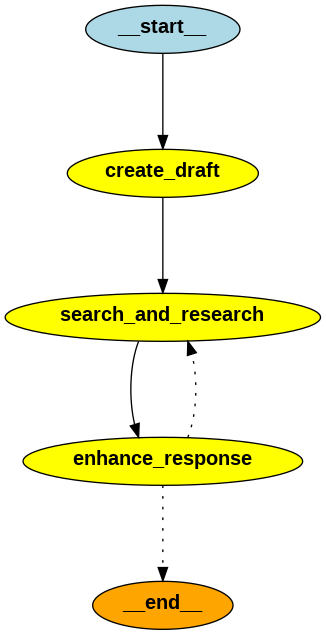

In [23]:
from IPython.display import Image, display

# Show the agent
display(Image(reflexion_workflow.get_graph().draw_png()))


### Testing

In [24]:
# Run the agent with the neural networks question
target_question = "How do neural networks actually learn?"

print(f"Running Reflexion agent with question: {target_question}")
print("=" * 60)

events = reflexion_workflow.stream(
    {"messages": [("user", target_question)]},
    stream_mode="values",
)

for i, step in enumerate(events):
    print(f"\nStep {i}")
    print("-" * 40)
    step["messages"][-1].pretty_print()

print("\n" + "=" * 60)
print("Reflexion agent execution completed!")

Running Reflexion agent with question: How do neural networks actually learn?

Step 0
----------------------------------------
================================ Human Message =================================

How do neural networks actually learn?

Step 1
----------------------------------------
================================== Ai Message ==================================

I'll provide a detailed explanation of how neural networks learn using the GenerateResponse function.
Tool Calls:
  GenerateResponse (toolu_bdrk_01DqGLJ3FewnonPBX697Fxu7)
 Call ID: toolu_bdrk_01DqGLJ3FewnonPBX697Fxu7
  Args:
    response: Neural networks learn through a process called backpropagation combined with gradient descent optimization. Here's how it works:

First, a neural network starts with random weights and biases connecting its neurons. During training, it processes input data through these connections, with each neuron applying an activation function to determine its output. This forward pass genera

The Reflexion agent will:
- Generate an initial technical explanation with self-critique
- Identify specific knowledge gaps requiring research
- Execute targeted web searches for current information
- Integrate findings into a comprehensive, cited response
- Repeat the process until the explanation meets quality standards